# Overlaying collider and Direct Detection Dark Matter constraints: an example notebook

Making up 85% of the matter in the universe, **dark matter** (DM) is sought by multiple experiments, following different theoretical hypotheses. Making progress on our understanding of the nature of dark matter requires a strategy that includes a variety of complementary experiments. In this notebook, we highlight the complementarity between two different classes of experiments, those at future colliders and direct detection experiments, using a benchmark model where the interactions between dark matter and known (Standard Model, or SM) particles are mediated by a new vector particle.  

**Credits**: This work is conducted in the context of the 2025 European Strategy Update, and is one of the projects in the initiative for Dark Matter in Europe and Beyond (https://iDMEu.org). The explanatory text in these cells is taken from [2] and [3]. This project has received funding from the European Research Council under the European Union’s Horizon 2020 research and innovation program (grant agreement 679305 and 101002463). The main authors of this notebook are Katherine Pachal (TRIUMF), Léo Chazallet (LAPP) and Caterina Doglioni (University of Manchester). 

## Introduction to the model and its parameters

The Feynman diagram of the model we are testing for collider experiments is below. The mediator is termed as $V$ ($A-V$ represents the axial vector mediator), quarks are denoted by $q$ and gluons by $g$, while the Dark Matter particle is called $\chi$.

The relevant parameters for this model are:
   * The coupling between quarks and the mediator $g_q$
   * The coupling between DM and the mediator $g_{DM}$
   * The mediator mass $m_V$
   * The dark matter mass $m_{DM}$

The model also allows for a single universal coupling strength $g_l$ for all mediator-lepton interactions, including neutrinos (this is not depicted in the diagrams below). No mixing with the Z-boson is included in this model.

While this is a _simplified model_, meaning that not all of its features are fully developed at all scales, portraying the sensitivities of different experiments using a common benchmark is still useful to understand how DM would manifest across experiments in similar classes of models. 

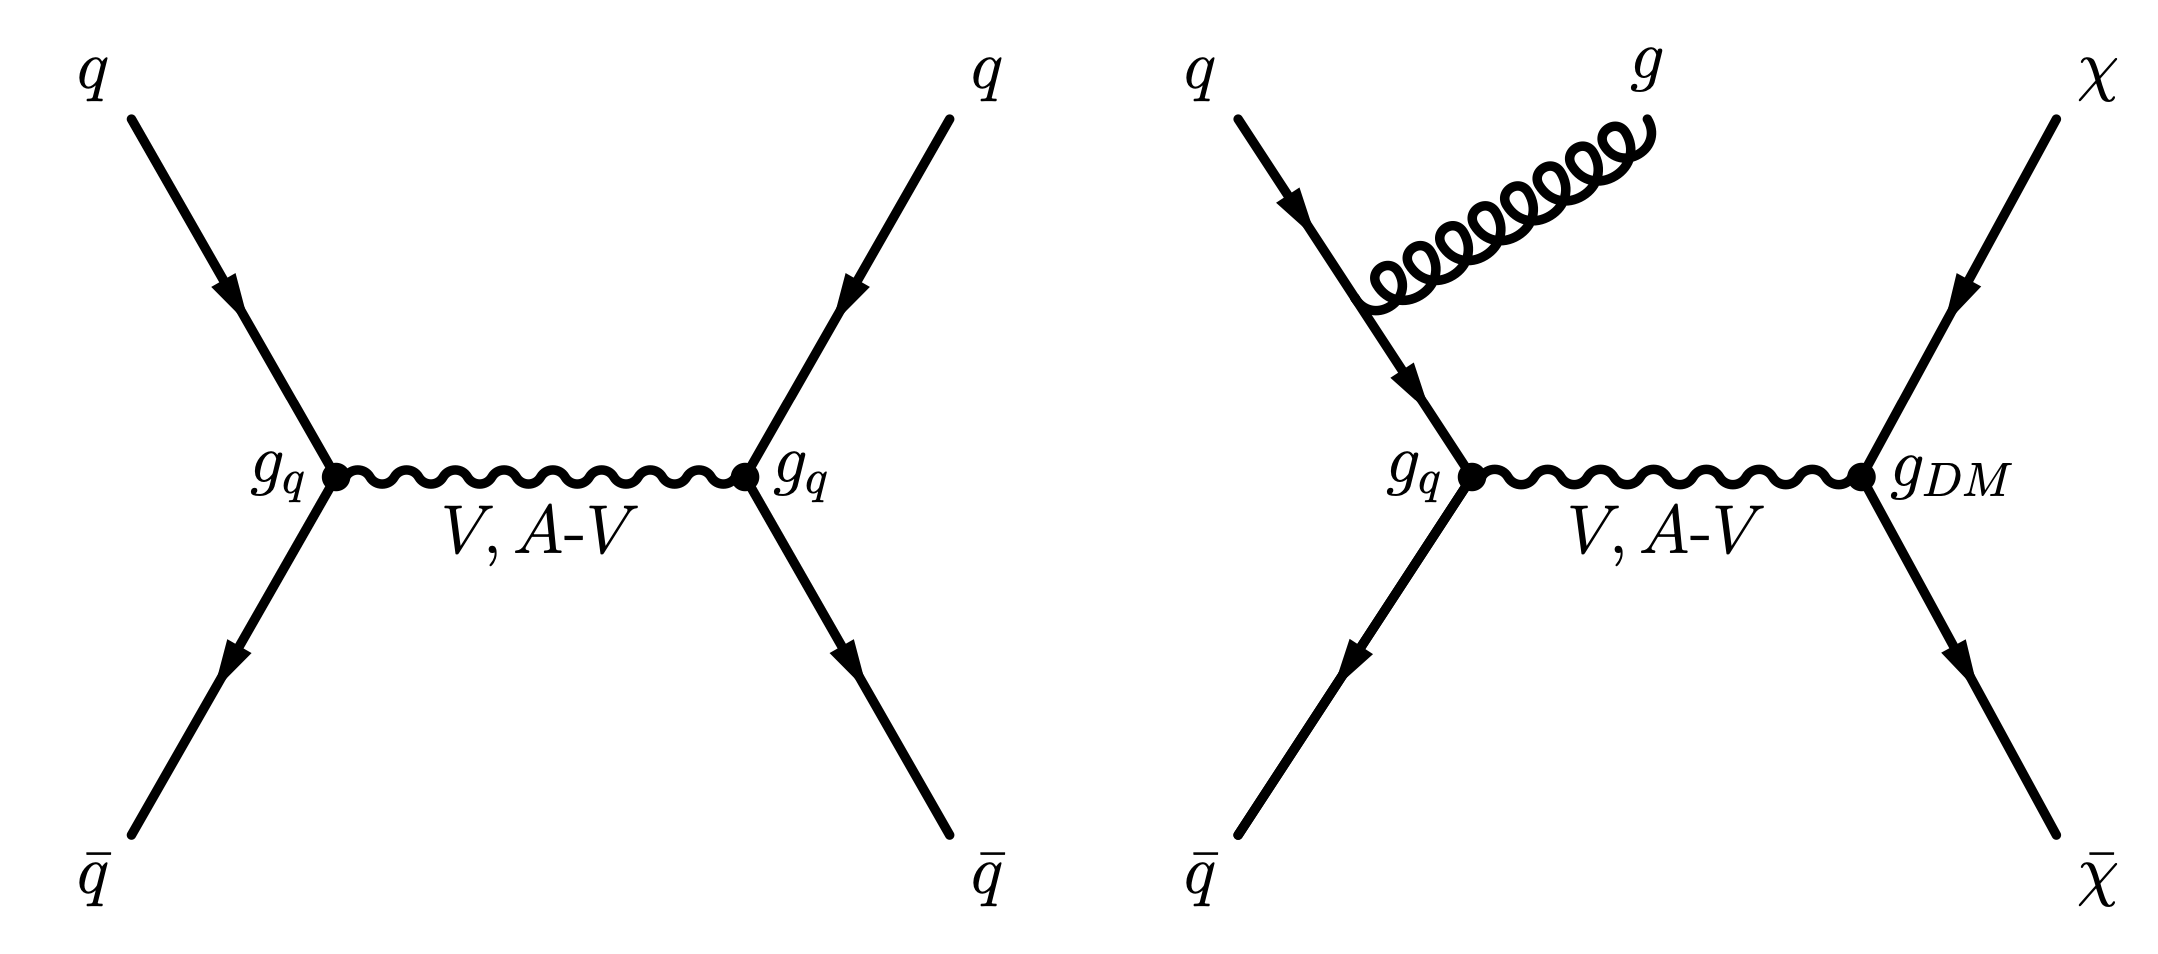

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "img/Feynman.png", width=600, height=300)

## Searches at colliders

Due to the presence of both SM and DM couplings, the main search avenues for this kind of models at colliders are (a, left-hand side diagram) by looking for localized (resonant) excesses signaling the presence of a mediator decaying into pairs of DM particles and (b, right-hand side diagram) by looking for an excess of missing energy (MET) from the mediator decaying to DM particles.  

The inputs received from the collider community in the context of Snowmass 2021 and used to prepare the plots in this notebook are: 
   * MET+jet search (also called monojet search) using the ATLAS detector at the upgraded LHC (HL-LHC) [hllhc-monojet];
   * MET+jet and MET+hadronically decaying vector boson at the Future Hadron Collider in the Future Circular Collider (FCC) complex [Harris:2015kda];
   * Dijet resonance search at the HL-LHC and at the Future Hadron Collider [Harris:2022kls];
   * Dilepton resonance search at the HL-LHC using the ATLAS detector [ATL-PHYS-PUB-2018-044]. The CMS version of this search is also available at [CMS-PAS-FTR-21-005].

## Motivation

[Explain that we need more than one experiment to make a discovery] 

So far, the presentation of LHC and future hadron collider results has focused on four benchmark scenarios with specific coupling values within these simplified models - in particular, one of the chosen benchmarks (also used in the 2019 European Strategy Briefing Book [4]) use g_q = 0.25, g_l = 0 and g_DM = 1.0. [The following is a WIP] In this work, we highlight the extensions of this benchmark scenario to arbitrary couplings and show how the areas of complementarity (where both direct detection and collider experiments could share information about a discovery) change under different coupling scenarios. 

## Notebook for overlaying the sensitivity of future collider and direct detection experiments 

### Common imports and functions

Assorted imports, including a helper script to collect and display direct detection curves

In [2]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from shapely.geometry import Polygon as shapely_pol
import pickle
from basic_plotter import *
import ROOT
import itertools as it
import sys, os
sys.path.insert(1, '../inputs/directdetection')
import collect_dd

FULL_SPECTRA_PATH = "data/Full_spectra"  # arXiv:[2109.03116]
OUTPUT_FOLDER = "plots"

import warnings
warnings.filterwarnings('ignore')

Some more helper functions (TODO: move outside this notebook at some point...)

In [3]:
def interpolate_vertical(x1,y1,x2,y2,n) :
    ov = sorted([[y1,x1],[y2,x2]])
    new_ys = np.linspace(ov[0][0], ov[1][0], num=n)
    new_xs = np.interp(new_ys,[ov[0][0],ov[1][0]],[ov[0][1],ov[1][1]])
    vertices = list(zip(new_xs,new_ys))
    return vertices if y1 < y2 else list(reversed(vertices))

In [4]:
# Collect direct detection contours for comparison plots.
def get_dd_lines(lineinfo) :
    legend_lines = list(lineinfo.keys())
    dd_lines = []
    for name in legend_lines :
        dd_lines.append(lineinfo[name])
    return legend_lines, dd_lines

In [5]:
def pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = it.tee(iterable)
    next(b, None)
    return zip(a, b)

### Plotting direct detection curves

#### Plotting one example curve by itself

Here we plot the Darkside example plot as an example of direct detection. WIP Leo: overlaying other future experiment projections. 

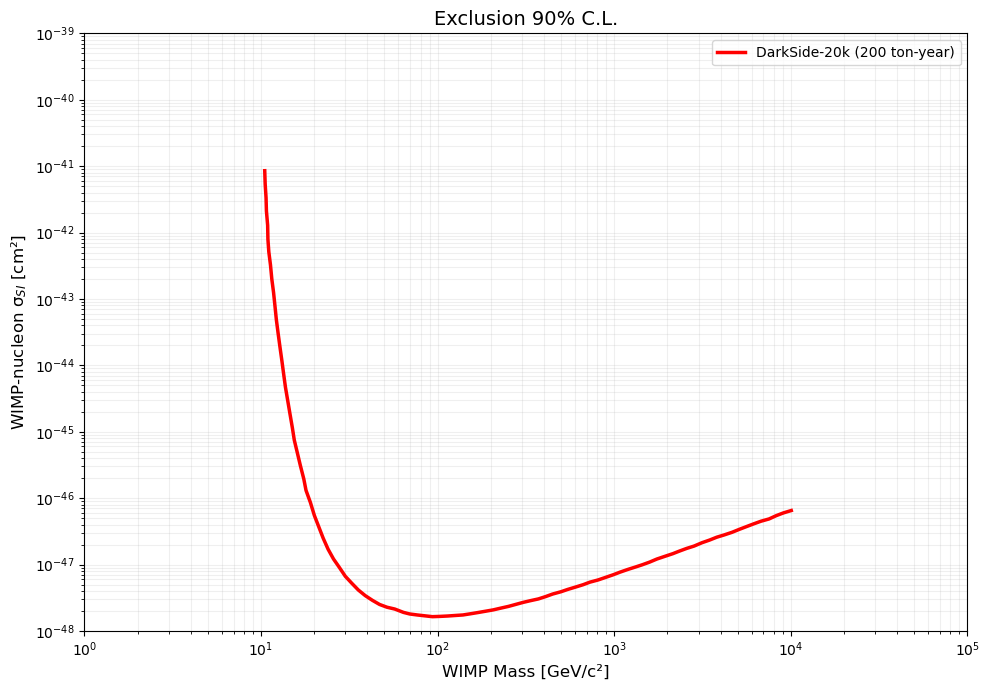

In [6]:
plt.figure(figsize=(10, 7))

# Define filenames for the full spectra
DS200TY_FULL_SPECTRUM_FILE = "DarkSide-200ty.txt"  # DS-20k 200 ton-year projection

# Load DarkSide-200ty full spectrum
try:
    # First try with comma delimiter
    try:
        ds200ty_mass, ds200ty_xsec = np.loadtxt(os.path.join(FULL_SPECTRA_PATH, DS200TY_FULL_SPECTRUM_FILE), 
                                          delimiter=',', unpack=True)
    except:
        # If comma fails, try tab delimiter
        ds200ty_mass, ds200ty_xsec = np.loadtxt(os.path.join(FULL_SPECTRA_PATH, DS200TY_FULL_SPECTRUM_FILE), 
                                          delimiter='\t', unpack=True)
    
    # Plot DS-200ty data
    plt.loglog(ds200ty_mass, ds200ty_xsec, '-', color='red', linewidth=2.5, 
             label='DarkSide-20k (200 ton-year)')
except Exception as e:
    print(f"Error loading DarkSide-200ty full spectrum: {e}")

# Set plot properties
plt.xlabel('WIMP Mass [GeV/c²]', fontsize=12)
plt.ylabel('WIMP-nucleon σ$_{SI}$ [cm²]', fontsize=12)
plt.title('Exclusion 90% C.L.', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(fontsize=10)

# Set axis limitsm
plt.xlim(1, 100000)  
plt.ylim(1e-48, 1e-39) 

# Save plot
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "full_spectra_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()

#### Preparing to plot multiple DD curves overlaid

Here we pick up the different constraints in terms of direct detection DM-nucleon interactions, spin-dependent for proton and neutron separately and spin-independent, and have a helper function that associates legends to curves. 

In [7]:
sd_proton = collect_dd.get_sd_proton()
sd_neutron = collect_dd.get_sd_neutron()
spin_independent = collect_dd.get_spin_independent()

In [8]:
spin_independent.update({'Darkside' : [np.array(ds200ty_mass),np.array(ds200ty_xsec)]})

In [9]:
# Collect direct detection contours for comparison plots.
def get_dd_lines(lineinfo) :
    legend_lines = list(lineinfo.keys())
    dd_lines = []
    for name in legend_lines :
        dd_lines.append(lineinfo[name])
    return legend_lines, dd_lines

### Plotting collider curves

We will now test a few couplings of the mediator to quarks (gq), leptons (gl) and dark matter (test_gdm), for the static version of the plots. The choice of these couplings does not change direct detection results, but they change the sensitivity of the collider results as they influence both production and decay of the mediator in a collider.    

In [10]:
test_gq = [0.25]
test_gdm = [1.0]
test_gl = [0.00]

These two following functions are used to convert benchmark points that are constrained in collider space, identified by the couplings, the mediator mass and the DM mass, into benchmark points in the direct detection space of the nucleon-DM spin-dependent and spin-independent cross-section (equation 4.10 and 4.3 of [2]). 
Note: these conversion formulas do not include effects due to the difference in energy scales of the two experiments [3], but they do not change the picture for the purpose of these plots. 

In [11]:
# eqn 4.10 https://arxiv.org/pdf/1603.04156.pdf#page12
def calculate_sd(gq, gdm, gl, mMed, mdm) :

    mn = 0.939 # GeV
    val = 2.4e-42 * (gq*gdm/0.25)**2 * (1000./mMed)**4 * (mn*mdm/(mn+mdm))**2
    return val

# eqn 4.3: https://arxiv.org/pdf/1603.04156.pdf#page12
def calculate_si(gq, gdm, gl, mMed, mdm) :

    mn = 0.939 # GeV
    val = 6.9e-41 * (gq*gdm/0.25)**2 * (1000./mMed)**4 * (mn*mdm/(mn+mdm))**2
    return val

This function takes care of the plotting given inputs in terms of collider name, kind of model (vector or axial vector mediator), contour lines, legend lines, and what couplings are fixed. 

In [12]:
def make_plots(collider, model, contours, legend_lines, fix_couplings, extra_tag = "") :
    xlow = 1
    xhigh = 2000 if 'hl-lhc' in collider else 4000
    if 'vector' in model : ylow = 1e-48 if 'hl-lhc' in collider else 1e-50
    else : ylow = 1e-46 if 'hl-lhc' in collider else 1e-50
    yhigh = 1e-37 if 'hl-lhc' in collider else 1e-42    
    usepath = "plots/directdetection/"+collider
    formatters = {"gq" : "q", "gdm" : "\chi", "gl" : "l"}
    treat_as_scaling = False
    # At least 2 fixed couplings.
    if len(fix_couplings.keys()) > 2 :
        label_line =  "{0}\n{7}, g$_{5}$={2}\ng$_{4}$={1}, g$_{6}$={3}".format(("Axial-vector" if 'axial' in model else "Vector"),fix_couplings["gq"],fix_couplings["gdm"],fix_couplings["gl"],"q","\chi","l",collider.upper())
        tag_line = model+"_gq{0}_gdm{1}_gl{2}".format(fix_couplings["gq"],fix_couplings["gdm"],fix_couplings["gl"])
    else :
        treat_as_scaling = True
        usecouplings = list(fix_couplings.keys())
        useformats = []
        vals = []
        for coupling in usecouplings :
            useformats.append(formatters[coupling])
            vals.append(fix_couplings[coupling])
        label_line = "{0}, {5}\ng$_{3}$={1}, g$_{4}$={2}".format(("Axial-vector" if 'axial' in model else "Vector"),vals[0],vals[1],useformats[0],useformats[1],collider.upper())
        tag_line = model+"_{0}{1}_{2}{3}".format(usecouplings[0],vals[0],usecouplings[1],vals[1])
    if extra_tag : tag_line = tag_line + "_" + extra_tag
    # And draw. First, version without DD experiment lines
    # Then draw the plots with DD lines on
    if 'vector' in model :
        # If doing fcc-hh, remove MIGD line which is too high up to be seen.
        formatted_lines = get_dd_lines(spin_independent)
        ddcurves = []
        ddnames = []
        for name, line in zip(formatted_lines[0],formatted_lines[1]) :
            if not ('fcc' in collider and 'MIGD' in name) :
                ddcurves.append(line)
                ddnames.append(name)
        use_ylabel = "$\sigma_{SI}$ ($\chi$-nucleon) [cm$^2$]"
        drawDDPlot(contours,legend_lines, this_tag = tag_line, plot_path = usepath, addText = label_line, ylabel=use_ylabel, is_scaling=treat_as_scaling, transluscent=treat_as_scaling, xhigh=xhigh, ylow=ylow, yhigh=yhigh)
        drawDDPlot(contours,legend_lines, this_tag = tag_line+"_withDD", plot_path = usepath, addText = label_line, ylabel=use_ylabel, is_scaling=treat_as_scaling, transluscent=treat_as_scaling, xhigh=xhigh, ylow=ylow, yhigh=yhigh, dd_curves = ddcurves, dd_legendlines = ddnames)
    else :
        use_ylabel = "$\sigma_{SD}$ ($\chi$-nucleon) [cm$^2$]"
        drawDDPlot(contours,legend_lines, this_tag = tag_line, plot_path = usepath, addText = label_line, ylabel=use_ylabel, is_scaling=treat_as_scaling, transluscent=treat_as_scaling, xhigh=xhigh, ylow=ylow, yhigh=yhigh)
        formatted_lines_p = get_dd_lines(sd_proton)
        use_ylabel = "$\sigma_{SD}$ ($\chi$-proton) [cm$^2$]"
        drawDDPlot(contours,legend_lines, this_tag = tag_line+"_withDD_proton", plot_path = usepath, addText = label_line, ylabel=use_ylabel, is_scaling=treat_as_scaling, transluscent=treat_as_scaling, xhigh=xhigh, ylow=ylow, yhigh=yhigh, dd_curves = formatted_lines_p[1], dd_legendlines = formatted_lines_p[0])  
        formatted_lines_n = get_dd_lines(sd_neutron)
        use_ylabel = "$\sigma_{SD}$ ($\chi$-neutron) [cm$^2$]"
        drawDDPlot(contours,legend_lines, this_tag = tag_line+"_withDD_neutron", plot_path = usepath, addText = label_line, ylabel=use_ylabel, is_scaling=treat_as_scaling, transluscent=treat_as_scaling, xhigh=xhigh, ylow=ylow, yhigh=yhigh, dd_curves = formatted_lines_n[1], dd_legendlines = formatted_lines_n[0])

Here we load all the files including polygons for the HL-LHC vector mediated DM benchmark models, and make different grids of plots with different options using python dictionaries. 

In [19]:
def load_polygons(model, collider):
    filename = f'{model}_exclusion_contours_{collider}.pkl'
    with open(filename, "rb") as f:
        return pickle.load(f)

def process_single_contour(contour, model, gq, gdm, gl):
    original_vertices = list(contour.exterior.coords)
    use_vertices = []
    n = len(original_vertices)
    for i in range(n):
        x, y = original_vertices[i]
        xnext, ynext = original_vertices[(i + 1) % n]
        use_vertices.append((x, y))
        if (y > 0 or ynext > 0) and ynext < 50:
            use_vertices.extend(interpolate_vertical(x, y, xnext, ynext, 100))

    contour_DD_raw = []
    raw_graph = ROOT.TGraph()
    calc_sigma = calculate_sd if model == 'axial' else calculate_si

    for x, y in use_vertices:
        sigma = calc_sigma(gq, gdm, gl, x, y)
        contour_DD_raw.append((y, sigma))
        raw_graph.AddPoint(y, sigma)

    return shapely_pol(contour_DD_raw)

def process_exclusions(loaded_polygons, model, test_gq, test_gdm, test_gl):
    exclusions_dd = {sig: {} for sig in ['dijet', 'monojet', 'dilepton']}
    exclusions_separate_dd = {sig: {} for sig in ['dijet', 'monojet', 'dilepton']}

    for gdm in test_gdm:
        for gq in test_gq:
            for gl in test_gl:
                for signature in exclusions_dd.keys():
                    key = (gq, gdm, gl)
                    if key not in loaded_polygons[signature]:
                        continue
                    exclusions = loaded_polygons[signature][key]
                    if not exclusions:
                        continue

                    inner_contours = [process_single_contour(c, model, gq, gdm, gl) for c in exclusions]

                    exclusions_dd[signature][key] = [inner_contours]
                    exclusions_separate_dd[signature][key] = inner_contours

    return exclusions_dd, exclusions_separate_dd

def plot_scan_1(collider, model, exclusions_dd, exclusions_separate_dd, test_gq, test_gdm, test_gl):
    for gdm in test_gdm:
        for gq in test_gq:
            contours_list_couplingscan = []
            legend_lines_couplingscan = []

            for gl in test_gl:
                contours_list = []
                legend_lines = []
                for signature in exclusions_dd.keys():
                    key = (gq, gdm, gl)
                    contours = exclusions_dd[signature].get(key)
                    if not contours:
                        continue
                    contours_list.extend(contours)
                    legend_lines.append(signature.capitalize())

                if contours_list:
                    make_plots(collider, model, contours_list, legend_lines, {"gq": gq, "gdm": gdm, "gl": gl})
                    full_polygons = merge_exclusions(contours_list)
                    if full_polygons:
                        contours_list_couplingscan.append(full_polygons)
                        legend_lines_couplingscan.append(f"g$_{{l}}$={gl}")

            if contours_list_couplingscan:
                make_plots(collider, model, contours_list_couplingscan, legend_lines_couplingscan, {"gq": gq, "gdm": gdm})

            for gl in test_gl:
                for signature in exclusions_separate_dd.keys():
                    sub_contours_list = []
                    sub_legends_list = []
                    for gq_val in test_gq:
                        contours = exclusions_separate_dd[signature].get((gq_val, gdm, gl))
                        if contours:
                            sub_contours_list.append(contours)
                            sub_legends_list.append(f"g$_{{q}}$={gq_val}")
                    if sub_contours_list:
                        make_plots(collider, model, sub_contours_list, sub_legends_list, {"gl": gl, "gdm": gdm}, extra_tag=signature)

def plot_scan_2(collider, model, exclusions_dd, test_gq, test_gdm, test_gl):
    for gl in test_gl:
        for gdm in test_gdm:
            contours_list_couplingscan = []
            legend_lines_couplingscan = []

            for gq in test_gq:
                contours_list = []
                for signature in exclusions_dd.keys():
                    contours = exclusions_dd[signature].get((gq, gdm, gl))
                    if contours:
                        contours_list.extend(contours)

                if contours_list:
                    full_polygons = merge_exclusions(contours_list)
                    if full_polygons:
                        contours_list_couplingscan.append(full_polygons)
                        legend_lines_couplingscan.append(f"g$_{{q}}$={gq}")

            if contours_list_couplingscan:
                make_plots(collider, model, contours_list_couplingscan, legend_lines_couplingscan, {"gl": gl, "gdm": gdm})

def plot_scan_3(collider, model, exclusions_dd, exclusions_separate_dd, test_gq, test_gdm, test_gl):
    for gq in test_gq:
        for gl in test_gl:
            contours_list_couplingscan = []
            legend_lines_couplingscan = []

            for gdm in test_gdm:
                contours_list = []
                for signature in exclusions_dd.keys():
                    contours = exclusions_dd[signature].get((gq, gdm, gl))
                    if contours:
                        contours_list.extend(contours)

                if contours_list and any(contours_list):
                    full_polygons = merge_exclusions(contours_list)
                    contours_list_couplingscan.append(full_polygons)
                    legend_lines_couplingscan.append(f"g$_{{\\chi}}$={gdm}")

            if contours_list_couplingscan:
                make_plots(collider, model, contours_list_couplingscan, legend_lines_couplingscan, {"gq": gq, "gl": gl})

            for signature in exclusions_separate_dd.keys():
                sub_contours_list = []
                sub_legends_list = []
                for gdm in test_gdm:
                    contours = exclusions_separate_dd[signature].get((gq, gdm, gl))
                    if contours:
                        sub_contours_list.append(contours)
                        sub_legends_list.append(f"g$_{{\\chi}}$={gdm}")
                if sub_contours_list:
                    make_plots(collider, model, sub_contours_list, sub_legends_list, {"gq": gq, "gl": gl}, extra_tag=signature)
for collider in ['hl-lhc']:  # , 'fcc-hh']:
    for model in ['vector']:  # , 'axial']:
        loaded_polygons = load_polygons(model, collider)

        exclusions_dd, exclusions_separate_dd = process_exclusions(loaded_polygons, model, test_gq, test_gdm, test_gl)

        plot_scan_1(collider, model, exclusions_dd, exclusions_separate_dd, test_gq, test_gdm, test_gl)
        plot_scan_2(collider, model, exclusions_dd, test_gq, test_gdm, test_gl)
        plot_scan_3(collider, model, exclusions_dd, exclusions_separate_dd, test_gq, test_gdm, test_gl)

In [ ]:
# Load pickle files with polygons
for collider in ['hl-lhc'] :#, 'fcc-hh'] :
    for model in ['vector'] : #,'axial'] :

        # Limits with fixed couplings
        with open('{0}_exclusion_contours_{1}.pkl'.format(model,collider), "rb") as poly_file:
            loaded_polygons = pickle.load(poly_file)

            # Grid of plots:
            exclusions_dd = {'dijet' : {},'monojet' : {},'dilepton' : {}}
            exclusions_separate_dd = {'dijet' : {},'monojet' : {},'dilepton' : {}}
            for gdm in test_gdm :
                for gq in test_gq :
                    contours_list_couplingscan = []
                    legend_lines_couplingscan = []                
                    for gl in test_gl :
                        contours_list = []
                        legend_lines = []
                        for signature in ['dijet','monojet','dilepton'] :
                            # e.g. no coupling to leptons, skip:
                            if (gq, gdm, gl) not in loaded_polygons[signature].keys() :
                                continue
                            exclusions = loaded_polygons[signature][(gq, gdm, gl)]
                            if not exclusions : continue
                            inner_contours = []
                            for contour in exclusions :
                                original_vertices = list(contour.exterior.coords)
                                use_vertices = []
                                # Reconnect loop by adding first one back
                                for (x, y), (xnext,ynext) in pairwise(original_vertices+[original_vertices[0]]):
                                    use_vertices.append((x, y))
                                    if (y > 0 or ynext > 0) and ynext < 50 :
                                        new_vertices = interpolate_vertical(x,y,xnext,ynext,100)
                                        use_vertices = use_vertices + new_vertices
                                contour_DD_raw = []
                                raw_graph = ROOT.TGraph()
                                for (x, y) in use_vertices :
                                    if model=='axial' :
                                        sigma = calculate_sd(gq, gdm, gl, x, y)
                                    else :
                                        sigma = calculate_si(gq, gdm, gl, x, y)
                                    contour_DD_raw.append((y, sigma))
                                    raw_graph.AddPoint(y, sigma)
                                contour_DD = shapely_pol(contour_DD_raw)
                                inner_contours.append(contour_DD)
                            contours_list.append(inner_contours)
                            legend_lines.append(signature.capitalize())
                            exclusions_dd[signature][(gq, gdm, gl)] = contours_list
                            exclusions_separate_dd[signature][(gq, gdm, gl)] = inner_contours
                        # First set of plots: 3 contours, one plot for every coupling combo
                        make_plots(collider, model, contours_list, legend_lines, {"gq" : gq, "gdm" : gdm, "gl" : gl})
                        full_polygons = merge_exclusions(contours_list)
                        if not full_polygons : continue 
                        contours_list_couplingscan.append(full_polygons)
                        legend_lines_couplingscan.append("g$_{0}$={1}".format("l",gl))
                    # Second set of plots: merge all contours; fix gq and vary gl.
                    # Note this is not meaningful where we don't have dilepton projections - skip then.
                    make_plots(collider, model, contours_list_couplingscan, legend_lines_couplingscan, {"gq" : gq, "gdm" : gdm})
                    # Could do signature only, fixed gq and varying gl, 
                    # but don't think we need it right now. Would go here.

                # Need second set of plots with gl fixed instead:
                for gl in test_gl :
                    contours_list_couplingscan = []
                    legend_lines_couplingscan = []
                    for gq in test_gq :
                        contours_list = []
                        for signature in ['dijet','monojet','dilepton'] :
                            # e.g. no coupling to leptons, skip:
                            if (gq, gdm, gl) not in exclusions_dd[signature].keys() :
                                continue
                            exclusions = exclusions_dd[signature][(gq, gdm, gl)]
                            contours_list+=exclusions
                        full_polygons = merge_exclusions(contours_list)
                        if not full_polygons : continue
                        contours_list_couplingscan.append(full_polygons)
                        legend_lines_couplingscan.append("g$_{0}$={1}".format("q",gq))
                    make_plots(collider, model, contours_list_couplingscan, legend_lines_couplingscan, {"gl" : gl, "gdm" : gdm})
                
                    # A version overlaying all monojet and overlaying all dijet, but not combining
                    for signature in ['dijet','monojet','dilepton'] :
                        sub_contours_list = []
                        sub_legends_list = []
                        for gq in test_gq :
                            if (gq, gdm, gl) not in exclusions_separate_dd[signature].keys() : continue
                            sub_contours_list.append(exclusions_separate_dd[signature][(gq, gdm, gl)])
                            sub_legends_list.append("g$_{0}$={1}".format("q",gq))
                        make_plots(collider, model, sub_contours_list, sub_legends_list, {"gl" : gl, "gdm" : gdm}, extra_tag = signature)
            # And now third set of plots with gq and gl fixed:
            for gq in test_gq :
                for gl in test_gl :
                    contours_list_couplingscan = []
                    legend_lines_couplingscan = []
                    for gdm in test_gdm :
                        contours_list = []
                        for signature in ['dijet','monojet','dilepton'] :
                            # e.g. no coupling to leptons, skip:
                            if (gq, gdm, gl) not in exclusions_dd[signature].keys() :
                                continue                            
                            exclusions = exclusions_dd[signature][(gq, gdm, gl)]
                            contours_list+=exclusions
                        if all(not i for i in contours_list) : continue
                        full_polygons = merge_exclusions(contours_list)
                        contours_list_couplingscan.append(full_polygons)
                        legend_lines_couplingscan.append("g$_{0}$={1}".format("\chi",gdm))
                    make_plots(collider, model, contours_list_couplingscan, legend_lines_couplingscan, {"gq" : gq, "gl" : gl})
                    # A version overlaying all monojet and overlaying all dijet, but not combining
                    for signature in ['dijet','monojet','dilepton'] :
                        sub_contours_list = []
                        sub_legends_list = []
                        for gdm in test_gdm :
                            if (gq, gdm, gl) not in exclusions_separate_dd[signature].keys() : continue
                            sub_contours_list.append(exclusions_separate_dd[signature][(gq, gdm, gl)])
                            sub_legends_list.append("g$_{0}$={1}".format("\chi",gdm))                   
                        make_plots(collider, model, sub_contours_list,sub_legends_list, {"gq" : gq, "gl" : gl}, extra_tag = signature)

References:

[1] A. Boveia et al., Dark Matter Benchmark Models for Early LHC Run-2 Searches: Report of the ATLAS/CMS Dark Matter Forum, https://doi.org/10.1016/j.dark.2019.100371 

[2] https://arxiv.org/pdf/2203.12035

[3] 

[4] https://arxiv.org/pdf/1603.04156#page12

[5] https://arxiv.org/abs/1411.3342
